# Analyze ELFIN data with xgboost

In [1]:
import xgboost as xgb

# For the kung fu of data manipulation
import pandas as pd

# Useful function to split a data set for train/test sets
from sklearn.model_selection import train_test_split

# this following like is a called a "magic": it tells the notebook to display figures inline
%matplotlib inline

In [2]:
params = {
    'learning_rate': 0.1,   # epsilon on slides
    'gamma': 0,             # minimum loss reduction to make a split 
    'max_depth': 10,        # maximum depth of the tree
    'n_estimators': 50,     # number of boosted trees to fit
    
    'base_score': 0.5,      # the initial prediction score of all instances, global bias.
    'colsample_bylevel': 1, # subsample ratio of columns for each split, in each level
    'colsample_bytree': 1,  # subsample ratio of columns when constructing each tree.
    'max_delta_step': 0,    # maximum delta step we allow each tree's weight estimation to be    
    'min_child_weight': 1,  # minimum sum of instance weight(hessian) needed in a child.
    'missing': None,        # how to represent missing value, defaults to np.nan
    'nthread': -1,          # number of parallel threads to run xgboost
    'objective': "reg:linear", # or 'binary:logistic'  or 
    'reg_alpha': 0,         # L1 regularization term on weights
    'reg_lambda': 1,        # L2 regularization term on weights
    'scale_pos_weight': 1,  # balance of positive and negative weights
    'seed': 0,              # randomness
    'verbosity': 1,         # formerly "silent", here 1 stands for only warnings
    'subsample': 1,         # subsample ratio of the training instance.
    
    # I do not really have a GPU on my laptop so I'll wait warming my hands with the CPU :)
    'predictor': "cpu_predictor", # or 'gpu_predictor'
    'tree_method': "auto"         # or "approx" or "(gpu_)hist" or "(gpu_)exact"
}

## Creating model object to be trained

In [3]:
# scikit-learn is needed for this form of model
model = xgb.XGBClassifier(**params)

## Getting data and splitting into train and test sets

In [4]:
data = pd.read_pickle('tlm_elfin.pickle')

In [5]:
data.head(2)

,tlm_time,tlm_pwr1_bat1_temp,tlm_pwr1_bat2_temp,tlm_bat_mon_1_vol,tlm_bat_mon_2_vol,tlm_bat_mon_1_curr,tlm_bat_mon_2_curr,tlm_bat_mon_1_avg_curr,tlm_bat_mon_2_avg_curr,tlm_bat_mon_1_acc_curr,...,tlm_adc_pb_1_curr,tlm_adc_pb_2_curr,tlm_tmps_1,tlm_tmps_2,tlm_tmps_3,tlm_tmps_4,tlm_acc_curr_bat1_rarc,tlm_acc_curr_bat2_rarc,tlm_acc_curr_bat1_rsrc,tlm_acc_curr_bat2_rsrc
date,,,,,,,,,,,,,,,,,,,,,
2018-10-22 00:26:07,2018-10-22 00:25:45,18.750,18.375,3.95768,3.84056,-54.231771,-150.260417,-53.190104,-155.729167,398.958335,...,21.994135,83.577713,13.8125,10.9375,10.9375,10.0625,18.0,96.0,18.0,96.0
2018-10-21 22:31:43,2018-10-21 22:25:56,15.875,15.750,4.00160,3.97720,2.994792,54.296875,-1.171875,51.171875,416.341148,...,0.000000,83.577713,4.6250,9.3125,9.6250,8.6875,19.0,98.0,19.0,98.0


In [6]:
# Drop the telemetry timestamp because it can be fit in the model
data = data.drop('tlm_time', axis=1)
data.head(2)

,tlm_pwr1_bat1_temp,tlm_pwr1_bat2_temp,tlm_bat_mon_1_vol,tlm_bat_mon_2_vol,tlm_bat_mon_1_curr,tlm_bat_mon_2_curr,tlm_bat_mon_1_avg_curr,tlm_bat_mon_2_avg_curr,tlm_bat_mon_1_acc_curr,tlm_bat_mon_2_acc_curr,...,tlm_adc_pb_1_curr,tlm_adc_pb_2_curr,tlm_tmps_1,tlm_tmps_2,tlm_tmps_3,tlm_tmps_4,tlm_acc_curr_bat1_rarc,tlm_acc_curr_bat2_rarc,tlm_acc_curr_bat1_rsrc,tlm_acc_curr_bat2_rsrc
date,,,,,,,,,,,,,,,,,,,,,
2018-10-22 00:26:07,18.750,18.375,3.95768,3.84056,-54.231771,-150.260417,-53.190104,-155.729167,398.958335,446.67969,...,21.994135,83.577713,13.8125,10.9375,10.9375,10.0625,18.0,96.0,18.0,96.0
2018-10-21 22:31:43,15.875,15.750,4.00160,3.97720,2.994792,54.296875,-1.171875,51.171875,416.341148,452.14844,...,0.000000,83.577713,4.6250,9.3125,9.6250,8.6875,19.0,98.0,19.0,98.0


## Training the XGBoost model with Mars Express Telemetry to predict tlm_pwr1_bat1_temp

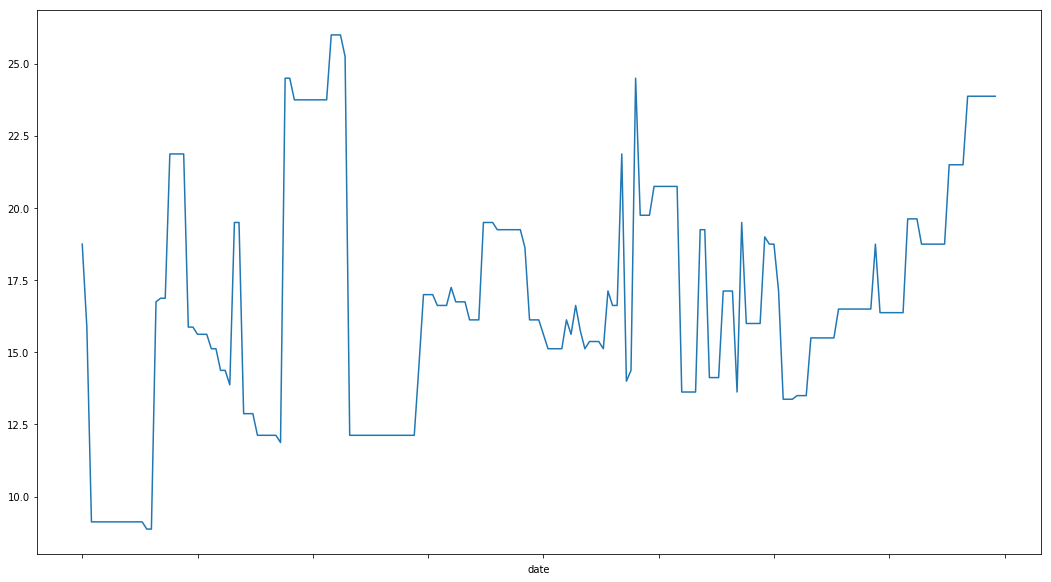

In [7]:
data.tlm_pwr1_bat1_temp.plot(figsize=(18,10))

In [8]:
# X represents all the features/predictors used to predict tlm_pwr1_bat1_temp
X = data.drop("tlm_pwr1_bat1_temp", axis=1)
Y = data.tlm_pwr1_bat1_temp

### Splitting the dataset into a train set 

In [9]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.33)

### Fitting the model

In [10]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=-1, objective='multi:softprob',
       predictor='cpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1,
       tree_method='auto')

In [11]:
# It took about 21minutes, 50 trees and about 6GB of RAM to fit the model.
X_train.shape

(133, 29)

### Using the trained model to make a prediction on the test set

In [12]:
from sklearn.metrics import mean_squared_error
y_test_prediction = model.predict(x_test)

/home/xabi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
err = mean_squared_error(y_test, y_test_prediction)
print(err)

1.2724905303030303


## Features importances

In [14]:
# Sorting and displaying feature importances

# importances is a list of tuples: (NAMEofCOLUMN, THISCOLUMN_IMPORTANCE)
importances = list(zip(data.columns, model.feature_importances_))

# Sort in reverse order for most important first
importances.sort(key=lambda x: x[1], reverse=True)

for F,I in importances:
    print("{}: {}".format(F,I))

tlm_pwr1_bat1_temp: 0.0934419184923172
tlm_adc_bat_2_vol: 0.08529789745807648
tlm_bat_mon_1_curr: 0.07586798071861267
tlm_bat_mon_2_avg_curr: 0.06986712664365768
tlm_adc_sa_34_vol: 0.06515216827392578
tlm_adc_pb_1_curr: 0.05872267484664917
tlm_adc_pb_2_curr: 0.05872267484664917
tlm_bat_mon_1_acc_curr: 0.057865411043167114
tlm_adc_sa_12_vol: 0.05400771647691727
tlm_bat_mon_2_curr: 0.0514359176158905
tlm_bat_mon_2_vol: 0.03943420574069023
tlm_adc_reg_sa_2_vol: 0.039005573838949203
tlm_adc_reg_sa_1_vol: 0.036862410604953766
tlm_tmps_1: 0.03471924737095833
tlm_tmps_3: 0.033433347940444946
tlm_pwr1_bat2_temp: 0.028289755806326866
tlm_bat_mon_1_vol: 0.02443206124007702
tlm_bat_mon_1_avg_curr: 0.02400342933833599
tlm_tmps_2: 0.023146163672208786
tlm_bus_1_vol: 0.01928846910595894
tlm_adc_bat_1_vol: 0.016716673970222473
tlm_adc_sa_56_vol: 0.005572224501520395
tlm_adc_sa_cc_curr: 0.003000428667291999
tlm_acc_curr_bat1_rarc: 0.0017145306337624788
tlm_bat_mon_2_acc_curr: 0.0
tlm_adc_reg_sa_3_vol: